import the libraries

In [48]:
import cv2
import os
import random
import numpy as np
import imgaug as ia
import tensorflow as tf
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

inspect original images

In [49]:
src = "crop"
dst = "train"
labels  = os.listdir(src)
for label in labels:
    path = os.path.join(src,label)
    imgs = os.listdir(path)
    print(f'{label}:{len(imgs)}')

brown:6
white:64
white2:10
black:755
red:11
white1:27


data augmentation

In [50]:
ia.seed(1)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Flipud(0.5), # vertical flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Brightness
    iaa.MultiplyBrightness((0.9, 1.1)),
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(0.5,iaa.GaussianBlur(sigma=(0, 0.5))),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 10% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.99, 1.01), per_channel=0.1),
    ], 
    random_order=True) # apply augmenters in random order

In [4]:
N = 8000
DIM = 100

dst = "train"
if not os.path.exists(dst):
    os.mkdir(dst)
    
for label in labels:
    path = os.path.join(dst,label)
    if not os.path.exists(path):
        os.mkdir(path)

for label in labels:
    path = os.path.join(src,label)
    imgs = os.listdir(path)
    m = len(imgs)
    k = N//m
    
    for i,img in enumerate(imgs):
        path = os.path.join(src,label,img)
        im = cv2.imread(path)
        ims = np.array([ im for _ in range(k)], dtype=np.uint8)
        imaugs = seq(images=ims)

        for j,au in enumerate(imaugs):
            name= label+str(i)+str(j)+".jpg"
            path = os.path.join(dst,label,name)
            au = cv2.resize(au,(DIM,DIM),interpolation=cv2.INTER_AREA)
            cv2.imwrite(path,au)

In [5]:
N = 3000
DIM = 100

dst = "test"
if not os.path.exists(dst):
    os.mkdir(dst)
    
for label in labels:
    path = os.path.join(dst,label)
    if not os.path.exists(path):
        os.mkdir(path)

for label in labels:
    path = os.path.join(src,label)
    imgs = os.listdir(path)
    m = len(imgs)
    k = N//m
    
    for i,img in enumerate(imgs):
        path = os.path.join(src,label,img)
        im = cv2.imread(path)
        ims = np.array([ im for _ in range(k)], dtype=np.uint8)
        imaugs = seq(images=ims)

        for j,au in enumerate(imaugs):
            name= label+str(i)+str(j)+".jpg"
            path = os.path.join(dst,label,name)
            au = cv2.resize(au,(DIM,DIM),interpolation=cv2.INTER_AREA)
            cv2.imwrite(path,au)

Create labels

In [18]:
dic={
    "black":0,
    "brown":1,
    "red":2,
    "white1":3,
    "white2":4,
    "white":5
}

Create a dataset

In [19]:
X = []
y = []

labels = os.listdir(dst)
for label in labels:
    path = os.path.join(dst,label)
    imgs = os.listdir(path)
    for img in imgs:
        path = os.path.join(dst,label,img)
        # read image
        x = cv2.imread(path)
        # convert hsv
        lab = cv2.cvtColor(x,cv2.COLOR_BGR2LAB)
        l = lab[:,:,0]
        a = lab[:,:,1]
        b = lab[:,:,2]
        hist1 = cv2.calcHist(l,[0],None,[256],[0,256])
        hist2 = cv2.calcHist(a,[0],None,[256],[0,256])
        hist3 = cv2.calcHist(b,[0],None,[256],[0,256])
        x = np.concatenate((hist1,hist2,hist3))
        x = x.ravel()
        X.append(x)
        y.append(dic[label])

no_classes = len(set(y))
print(no_classes)

#convert to numpy array
X = np.array(X)
y = np.array(y)

print("X:",X.shape)
print("y:",y.shape)


6
X: (16836, 768)
y: (16836,)


In [20]:
# shuffle
X,y = shuffle(X,y)

In [21]:
# split
X_train, X_val, y_train, y_val = train_test_split(X,y)
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_val",X_val.shape)
print("X_val",y_val.shape)

X_train (12627, 768)
y_train (12627,)
X_val (4209, 768)
X_val (4209,)


**NN1**

In [29]:
# build model
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(768,)),
    # tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(no_classes,activation='softmax')
])

# compile model
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               196864    
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dense_16 (Dense)            (None, 6)                 390       
                                                                 
Total params: 213,702
Trainable params: 213,702
Non-trainable params: 0
_________________________________________________________________


In [30]:
# train model
epochs = 10
history = model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=epochs)

Epoch 1/10
395/395 [==============================] - 1s 2ms/step - loss: 0.3070 - accuracy: 0.8929 - val_loss: 0.2163 - val_accuracy: 0.9173
Epoch 2/10
395/395 [==============================] - 1s 1ms/step - loss: 0.1555 - accuracy: 0.9415 - val_loss: 0.2225 - val_accuracy: 0.9147
Epoch 3/10
395/395 [==============================] - 0s 1ms/step - loss: 0.1331 - accuracy: 0.9471 - val_loss: 0.1606 - val_accuracy: 0.9366
Epoch 4/10
395/395 [==============================] - 0s 1ms/step - loss: 0.1203 - accuracy: 0.9529 - val_loss: 0.1504 - val_accuracy: 0.9437
Epoch 5/10
395/395 [==============================] - 0s 1ms/step - loss: 0.1091 - accuracy: 0.9579 - val_loss: 0.1521 - val_accuracy: 0.9408
Epoch 6/10
395/395 [==============================] - 0s 1ms/step - loss: 0.1011 - accuracy: 0.9602 - val_loss: 0.1560 - val_accuracy: 0.9408
Epoch 7/10
395/395 [==============================] - 0s 1ms/step - loss: 0.0941 - accuracy: 0.9635 - val_loss: 0.1442 - val_accuracy: 0.9439
Epoch 

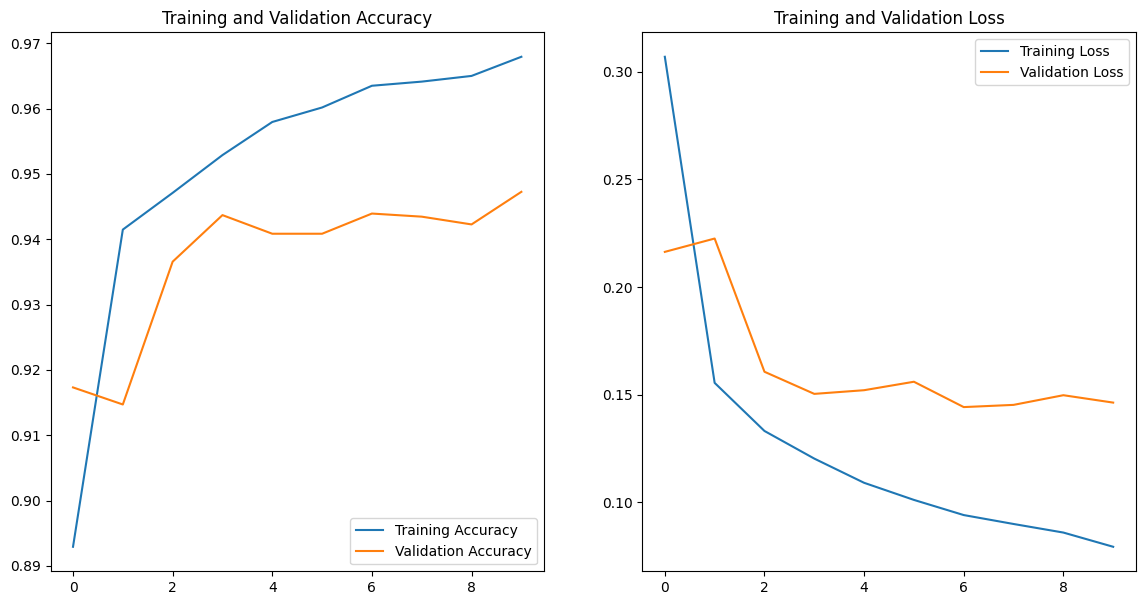

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Export model

In [43]:
model_name = 'nn1'
model.save(model_name)

INFO:tensorflow:Assets written to: nn1/assets


INFO:tensorflow:Assets written to: nn1/assets


Load model

In [44]:
loaded_model = tf.keras.models.load_model(model_name)
loaded_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 256)               196864    
                                                                 
 dense_15 (Dense)            (None, 64)                16448     
                                                                 
 dense_16 (Dense)            (None, 6)                 390       
                                                                 
Total params: 213,702
Trainable params: 213,702
Non-trainable params: 0
_________________________________________________________________


In [45]:
X = []
y = []

dst = "test"

labels = os.listdir(dst)
for label in labels:
    path = os.path.join(dst,label)
    imgs = os.listdir(path)
    for img in imgs:
        path = os.path.join(dst,label,img)
        # read image
        x = cv2.imread(path)
        # convert hsv
        lab = cv2.cvtColor(x,cv2.COLOR_BGR2LAB)
        l = lab[:,:,0]
        a = lab[:,:,1]
        b = lab[:,:,2]
        hist1 = cv2.calcHist(l,[0],None,[256],[0,256])
        hist2 = cv2.calcHist(a,[0],None,[256],[0,256])
        hist3 = cv2.calcHist(b,[0],None,[256],[0,256])
        x = np.concatenate((hist1,hist2,hist3))
        x = x.ravel()
        X.append(x)
        y.append(dic[label])
        
# convert to numpy array
X = np.array(X)
y = np.array(y)

print("X:",X.shape)
print("y:",y.shape)

X: (16836, 768)
y: (16836,)


In [46]:
preds = loaded_model.predict(X)
preds.shape

527/527 [==============================] - 0s 529us/step


(16836, 6)

In [47]:
count = 0
for i in range(preds.shape[0]):
    pred = np.argmax(preds[i])
    if pred == y[i]:
        count+=1

print(f'accuracy {count/preds.shape[0]},{count}/{preds.shape[0]}')

accuracy 0.9675694939415538,16290/16836


**SVM**

# references

[save and load model](https://www.tensorflow.org/guide/keras/save_and_serialize)

[cifar-10](https://www.geeksforgeeks.org/cifar-10-image-classification-in-tensorflow/)

[basic classification](https://www.tensorflow.org/tutorials/keras/classification)

[images classification](https://www.tensorflow.org/tutorials/images/classification)